In [4]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


In [5]:
def loadData():
  Data=mnist.load_data()
  (x_train,_),(_,_)=Data
  x_train=(x_train.astype("float32")-127.5)/127.5
  x_train=np.expand_dims(x_train,-1)
  return tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128).prefetch(tf.data.experimental.AUTOTUNE)



In [6]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model


def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model
def get_optimizers():
    return tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.Adam(1e-4)


generator = build_generator()
discriminator = build_discriminator()
g_opt, d_opt = get_optimizers()
loss_fn = tf.keras.losses.BinaryCrossentropy()





/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
@tf.function  # Compiles to a TensorFlow graph for speed
def train_step(images):
    noise = tf.random.normal([128, 100]) # creates a batch of 128 random noise vectors, each of size 100-dimensional

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) # generator takes the random noise as input and produces fake images resembling real MNIST digits
        real_output = discriminator(images, training=True) # discriminator predicts whether real MNIST images are real (should be close to 1)
        fake_output = discriminator(generated_images, training=True) # discriminator predicts whether the generated (fake) images are real (should be close to 0)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output) # tf.ones_like(fake_output) creates a tensor of ones, representing "real" labels
                                                                   # loss_fn (Binary Crossentropy loss) measures how close fake_output is to 1
                                                                   # lower generator loss means the generator is successfully fooling the discriminator
                                                                   # higher generator loss means the generator is performing poorly
        disc_loss = (loss_fn(tf.ones_like(real_output), real_output) + # how well the discriminator classifies real images as real (close to 1)
                     loss_fn(tf.zeros_like(fake_output), fake_output)) # how well the discriminator classifies fake images as fake (close to 0)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # compute gradients for generator parameters
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # compute gradients for discriminator parameters

    g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # update the generator's weights
    d_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # updates the discriminator's weight

    return gen_loss, disc_loss

def train(dataset, epochs=20):
    for epoch in range(epochs):
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")

def generate_and_show():
    noise = tf.random.normal([16, 100])
    images = generator(noise, training=False)
    images = (images + 1) / 2  # Rescale to [0,1]
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, 0], cmap='gray')
        ax.axis('off')
    plt.show()

# Load data and train


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1, Gen Loss: 1.4184, Disc Loss: 0.6481
Epoch 2, Gen Loss: 0.7171, Disc Loss: 1.4844
Epoch 3, Gen Loss: 0.8284, Disc Loss: 1.4168
Epoch 4, Gen Loss: 0.8637, Disc Loss: 1.4605
Epoch 5, Gen Loss: 1.3052, Disc Loss: 0.8432
Epoch 6, Gen Loss: 1.1338, Disc Loss: 0.9629
Epoch 7, Gen Loss: 1.2155, Disc Loss: 1.0124
Epoch 8, Gen Loss: 1.2008, Disc Loss: 0.9823
Epoch 9, Gen Loss: 1.2484, Disc Loss: 1.2087
Epoch 10, Gen Loss: 1.0097, Disc Loss: 1.0140


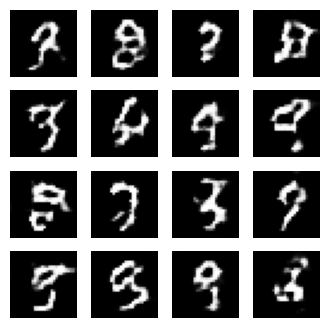

In [8]:
mnist_data = loadData()
train(mnist_data, epochs=10)
generate_and_show()
